<a href="https://colab.research.google.com/github/nadiaft72/Book-Summary-Analysis-and-Visualization/blob/main/BookSummaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch transformers
!pip install --upgrade transformers accelerate
!pip install diffusers
!pip install --upgrade rouge

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image, ImageDraw, ImageFont
from transformers import BartForConditionalGeneration, BartTokenizer
import json
import nltk
from transformers import pipeline
from diffusers import StableDiffusionPipeline
import torch
import itertools

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Data Preprocessing and EDA:


   - Clean the data by handling missing values.
   - Explore the dataset to understand its characteristics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Data Colab/booksummaries.txt"

with open(DATA_PATH, "r", encoding="latin-1") as f:
    book_lines = [line.strip().split("\t") for line in f.readlines()]
def extract_genres(genre_str):
    if genre_str :
      genre_str = genre_str.strip('{}')
      genre_dict = json.loads('{' + genre_str + '}')
      genres = [genre.replace('/m/', '').strip() for genre in genre_dict.values()]
      return genres
    return []

def extract_book_info(book):
    return {
        "id": book[0],
        "title": book[2],
        "author": book[3],
        "publication_date": book[4],
        "genres": extract_genres(book[5]),
        "summary": book[6],
    }

processed_data = [extract_book_info(book) for book in book_lines if len(book)>6]
df = pd.DataFrame(processed_data)
df.head()


id                                      title           author  \
0   620                                Animal Farm    George Orwell   
1   843                         A Clockwork Orange  Anthony Burgess   
2   986                                 The Plague     Albert Camus   
3  1756  An Enquiry Concerning Human Understanding       David Hume   
4  2080                       A Fire Upon the Deep     Vernor Vinge   

  publication_date                                             genres  \
0       1945-08-17  [Roman à clef, Satire, Children's literature, ...   
1             1962  [Science Fiction, Novella, Speculative fiction...   
2             1947  [Existentialism, Fiction, Absurdist fiction, N...   
3                                                                  []   
4                   [Hard science fiction, Science Fiction, Specul...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...

In [ ]:
df.shape

(16555, 6)

In [ ]:
df.columns

Index(['id', 'title', 'author', 'publication_date', 'genres', 'summary'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16555 entries, 0 to 16554
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                16555 non-null  object
 1   title             16555 non-null  object
 2   author            16555 non-null  object
 3   publication_date  16555 non-null  object
 4   genres            12839 non-null  object
 5   summary           16555 non-null  object
dtypes: object(6)
memory usage: 776.1+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16555 entries, 0 to 16554
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                16555 non-null  object
 1   title             16555 non-null  object
 2   author            16555 non-null  object
 3   publication_date  16555 non-null  object
 4   genres            15394 non-null  object
 5   summary           16555 non-null  object
dtypes: object(6)
memory usage: 776.1+ KB


In [ ]:
df.describe()

id    title author publication_date genres  \
count   16555    16555  16555            16555  16555   
unique  16555    16273   4712             2640   2155   
top       620  Nemesis                             []   
freq        1        6   2381             5608   3716   

                                     summary  
count                                  16555  
unique                                 16528  
top      ~Plot outline description~ --> <!--  
freq                                      13

In [ ]:
df.iloc[0]

id                                                                620
title                                                     Animal Farm
author                                                  George Orwell
publication_date                                           1945-08-17
genres              [Roman à clef, Satire, Children's literature, ...
summary              Old Major, the old boar on the Manor Farm, ca...
Name: 0, dtype: object

In [ ]:
df['publication_date'] = df['publication_date'].astype(str)
df['publication_date'] = df['publication_date'].str.extract('(\d{4})', expand=False)

df.head(10)

id                                      title                author  \
0   620                                Animal Farm         George Orwell   
1   843                         A Clockwork Orange       Anthony Burgess   
2   986                                 The Plague          Albert Camus   
3  1756  An Enquiry Concerning Human Understanding            David Hume   
4  2080                       A Fire Upon the Deep          Vernor Vinge   
5  2152             All Quiet on the Western Front  Erich Maria Remarque   
6  2890                       A Wizard of Earthsea     Ursula K. Le Guin   
7  2950                         Anyone Can Whistle       Arthur Laurents   
8  4081            Blade Runner 3: Replicant Night           K. W. Jeter   
9  4082          Blade Runner 2: The Edge of Human           K. W. Jeter   

  publication_date                                             genres  \
0             1945  [Roman à clef, Satire, Children's literature, ...   
1             1962  [Science Fiction, Novella, Speculative fiction...   
2             1947  [Existentialism, Fiction, Absurdist fiction, N...   
3              NaN                                                 []   
4              NaN  [Hard science fiction, Science Fiction, Specul...   
5             1929                          [War novel, Roman à clef]   
6             1968  [Children's literature, Fantasy, Speculative f...   
7              NaN                                                 []   
8             1996             [Science Fiction, Speculative fiction]   
9             1995             [Science Fiction, Speculative fiction]   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...  
5   The book tells the story of Paul Bäumer, a Ge...  
6   Ged is a young boy on Gont, one of the larger...  
7   The story is set in an imaginary American tow...  
8   Living on Mars, Deckard is acting as a consul...  
9   Beginning several months after the events in ...

#### Calculate the average publication year for each author and fill in the missing values with the average for that author.

In [ ]:
author_avg_year = {}
for author in df['author'].unique():
    author_df = df[df['author'] == author]
    valid_years = author_df['publication_date'].dropna().astype(int)
    if not valid_years.empty:
        author_avg_year[author] = str(int(valid_years.mean()))

print(author_avg_year)


{'George Orwell': '1938', 'Anthony Burgess': '1973', 'Albert Camus': '1962', 'Vernor Vinge': '1992', 'Erich Maria Remarque': '1943', 'Ursula K. Le Guin': '1977', 'K. W. Jeter': '1994', '': '1987', 'J. G. Ballard': '1978', 'Frank Herbert': '1973', 'Voltaire': '1753', 'Sheridan Le Fanu': '1866', 'John Irving': '1987', 'Bram Stoker': '1894', 'Miguel de Cervantes': '1595', 'Daniel Dennett': '1995', 'Franz Kafka': '1922', 'Ray Bradbury': '1960', 'J. R. R. Tolkien': '1955', 'Dorothy L. Sayers': '1930', 'Margaret Mitchell': '1936', 'Joseph Conrad': '1905', 'William Shakespeare': '1634', 'Mark Twain': '1889', 'Walter Scott': '1821', 'Dalton Trumbo': '1959', 'Kim Stanley Robinson': '1996', 'Douglas Coupland': '1999', 'Herman Melville': '1852', 'J. Meade Falkner': '1898', 'William Gibson': '1993', 'Neal Stephenson': '2000', 'Naomi Klein': '2003', 'Carl von Clausewitz': '1832', 'Philip K. Dick': '1971', 'Jane Austen': '1815', 'Vladimir Vladimirovich Nabokov': '1941', 'Tom Stoppard': '1972', 'Larr

In [ ]:
df['publication_date'].fillna(
    df['author'].map(lambda author: author_avg_year.get(author)), inplace=True
)

In [ ]:
df.head(10)

id                                      title                author  \
0   620                                Animal Farm         George Orwell   
1   843                         A Clockwork Orange       Anthony Burgess   
2   986                                 The Plague          Albert Camus   
3  1756  An Enquiry Concerning Human Understanding            David Hume   
4  2080                       A Fire Upon the Deep          Vernor Vinge   
5  2152             All Quiet on the Western Front  Erich Maria Remarque   
6  2890                       A Wizard of Earthsea     Ursula K. Le Guin   
7  2950                         Anyone Can Whistle       Arthur Laurents   
8  4081            Blade Runner 3: Replicant Night           K. W. Jeter   
9  4082          Blade Runner 2: The Edge of Human           K. W. Jeter   

  publication_date                                             genres  \
0             1945  [Roman à clef, Satire, Children's literature, ...   
1             1962  [Science Fiction, Novella, Speculative fiction...   
2             1947  [Existentialism, Fiction, Absurdist fiction, N...   
3             None                                                 []   
4             1992  [Hard science fiction, Science Fiction, Specul...   
5             1929                          [War novel, Roman à clef]   
6             1968  [Children's literature, Fantasy, Speculative f...   
7             None                                                 []   
8             1996             [Science Fiction, Speculative fiction]   
9             1995             [Science Fiction, Speculative fiction]   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...  
5   The book tells the story of Paul Bäumer, a Ge...  
6   Ged is a young boy on Gont, one of the larger...  
7   The story is set in an imaginary American tow...  
8   Living on Mars, Deckard is acting as a consul...  
9   Beginning several months after the events in ...

#### For each author, we calculate the up to 2 most frequent genres they have worked on, and then fill in any empty genre fields with these genres if the author has one.

In [ ]:
author_genre_counts = {}

for index, row in df.iterrows():
    author = row['author']
    genres = row['genres']

    if author not in author_genre_counts:
        author_genre_counts[author] = {}

    if not genres:
        genres = []

    for genre in genres:
        if genre in author_genre_counts[author]:
            author_genre_counts[author][genre] += 1
        else:
            author_genre_counts[author][genre] = 1

for author, genre_counts in author_genre_counts.items():
    top_2_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:2]
    author_genre_counts[author] = {genre: count for genre, count in top_2_genres}

print(author_genre_counts)

{'George Orwell': {'Fiction': 5, 'Novel': 3}, 'Anthony Burgess': {'Speculative fiction': 16, 'Historical novel': 4}, 'Albert Camus': {'Existentialism': 5, 'Fiction': 2}, 'David Hume': {}, 'Vernor Vinge': {'Science Fiction': 6, 'Speculative fiction': 5}, 'Erich Maria Remarque': {'War novel': 3, 'Roman à clef': 1}, 'Ursula K. Le Guin': {'Speculative fiction': 17, 'Science Fiction': 15}, 'Arthur Laurents': {}, 'K. W. Jeter': {'Science Fiction': 5, 'Speculative fiction': 5}, '': {'Science Fiction': 145, "Children's literature": 123}, 'J. G. Ballard': {'Speculative fiction': 14, 'Fiction': 12}, 'Frank Herbert': {'Science Fiction': 19, 'Speculative fiction': 17}, 'Voltaire': {'Satire': 2, 'Bildungsroman': 2}, 'Sheridan Le Fanu': {'Gothic fiction': 2, 'Thriller': 1}, 'John Irving': {'Fiction': 4, 'Novel': 4}, 'Bram Stoker': {'Speculative fiction': 3, 'Science Fiction': 2}, 'Miguel de Cervantes': {'Fiction': 2, 'Parody': 1}, 'Daniel Dennett': {'Philosophy': 3, 'Science': 2}, 'Richard Aldington

In [ ]:
def fill_genres(row, author_genre_counts):
    if not row['genres']:
        return list(author_genre_counts[row['author']].keys())
    else:
        return row['genres']

df['genres'] = df.apply(fill_genres, axis=1, args=(author_genre_counts,))

#### Finally, we impute empty genre lists with the two most frequent genres and replace missing publication years with the median of all publication years.

In [ ]:

median_date = df['publication_date'].median()
df['publication_date'].fillna(median_date, inplace=True)

def impute_genres(genre_list):
    if not genre_list:
        top_2_genres = df['genres'].mode().values[0][:2].tolist()
        return top_2_genres
    else:
        return genre_list

df['genres'] = df['genres'].apply(impute_genres)

df['publication_date'] = pd.to_numeric(df['publication_date'])



In [ ]:
AUTHOR_NA_VALUE = "Unknown"
DATE_NA_VALUE = "Unknown"

df["author"].replace("", AUTHOR_NA_VALUE, inplace=True)
df["publication_date"].replace("", DATE_NA_VALUE, inplace=True)

df.replace("", np.NAN, inplace=True)


df.head()


### Visualization

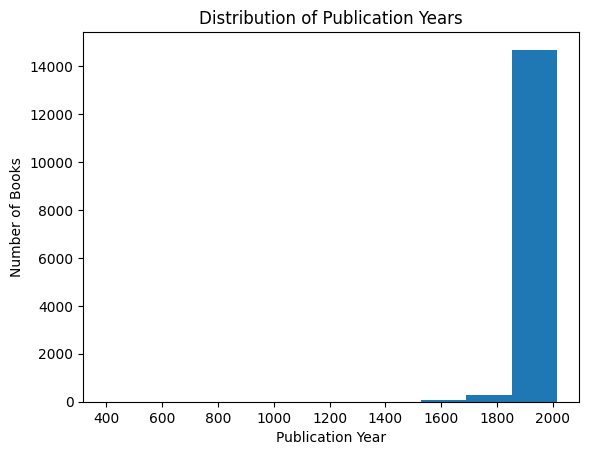

In [ ]:
df['publication_date'] = pd.to_numeric(df['publication_date'], errors='coerce')

df_filtered = df.dropna(subset=['publication_date'])

plt.hist(df_filtered['publication_date'])
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.title('Distribution of Publication Years')
plt.show()

Text(0.5, 0, 'Count')

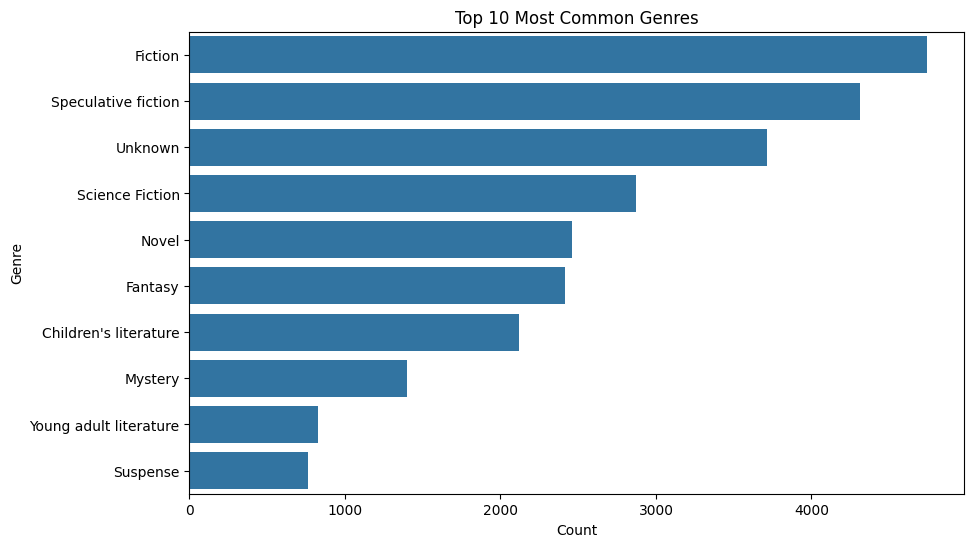

In [ ]:
genres = list(itertools.chain.from_iterable(df['genres']))

genre_counts = pd.Series(genres).value_counts().reset_index(name='Count')
genre_counts.columns = ['Genre', 'Count']

top_10_genres = genre_counts.nlargest(10, 'Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Genre', data=top_10_genres)
plt.title("Top 10 Most Common Genres")
plt.xlabel("Count")

<ipython-input-27-cb6d4b9d51e7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(title_lengths)


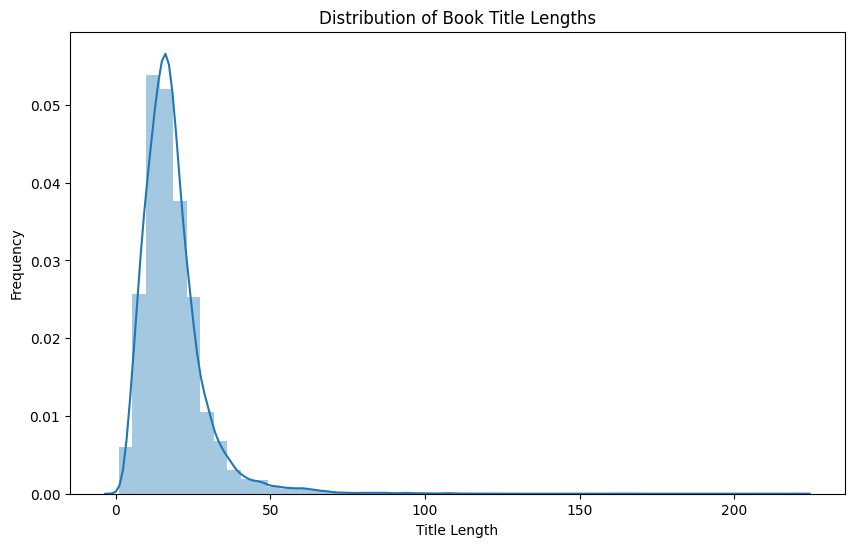

In [ ]:
title_lengths = df['title'].apply(len)
plt.figure(figsize=(10, 6))
sns.distplot(title_lengths)
plt.title("Distribution of Book Title Lengths")
plt.xlabel("Title Length")
plt.ylabel("Frequency")
plt.show()

# 2. NLP Component:
   - Condense the book summaries to make them shorter.


In [ ]:
 csv_file = '/content/drive/MyDrive/Data Colab/book_summariesed.csv'
 df = pd.read_csv(csv_file)


In [ ]:
def condense_summaries(data, pos, model_name="facebook/bart-large-cnn"):
    """Condenses book summaries using a pre-trained BART model.

    Args:
        df (pandas.DataFrame): The DataFrame containing book summaries.
        model_name (str, optional): The name of the pre-trained BART model. Defaults to "facebook/bart-large-cnn".

    Returns:
        dict: A dict of original summaries and condensed_summary.
    """

    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_name)
    if torch.cuda.is_available():
      model.to('cuda')

    summaries = []
    original_texts = []

    for i, summary in enumerate(data["summary"]):
        inputs = tokenizer.encode(f"summarize: {summary}", return_tensors="pt", max_length=1024, truncation=True)
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
        summary_ids = model.generate(
            inputs,
            max_length=150,
            min_length=40,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )
        condensed_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        df.loc[pos + i, "condensed_summary"] = condensed_summary
        summaries.append(condensed_summary)
        original_texts.append(summary)
        print("summary " + str(i) +" Done")

    new_df = pd.DataFrame({
        "condensed_summary": summaries,
        "summary": original_texts
    })

    return new_df



In [ ]:
batch_size = 100
# df_copy = df
# df["condensed_summary"] = None
df.shape


(16555, 8)

In [ ]:
df.head()

id                                      title           author  \
0   620                                Animal Farm    George Orwell   
1   843                         A Clockwork Orange  Anthony Burgess   
2   986                                 The Plague     Albert Camus   
3  1756  An Enquiry Concerning Human Understanding       David Hume   
4  2080                       A Fire Upon the Deep     Vernor Vinge   

  publication_date                                             genres  \
0       1945-08-17  ['Roman à clef', 'Satire', "Children's literat...   
1             1962  ['Science Fiction', 'Novella', 'Speculative fi...   
2             1947  ['Existentialism', 'Fiction', 'Absurdist ficti...   
3          Unknown                                        ['Unknown']   
4          Unknown  ['Hard science fiction', 'Science Fiction', 'S...   

                                             summary  publication_year  \
0   Old Major, the old boar on the Manor Farm, ca...            1945.0   
1   Alex, a teenager living in near-future Englan...            1962.0   
2   The text of The Plague is divided into five p...            1947.0   
3   The argument of the Enquiry proceeds by a ser...               NaN   
4   The novel posits that space around the Milky ...               NaN   

                                   condensed_summary  
0  Old Major, the old boar on the Manor Farm, cal...  
1  Alex, a teenager living in near-future England...  
2  Thousands of rats die in the streets of the to...  
3  The argument of the Enquiry proceeds by a seri...  
4  The novel posits that space around the Milky W...

In [ ]:
first_none_row = df[df['condensed_summary'].isna()].index[0]
first_none_row

8127

In [ ]:
for i in range(first_none_row, len(df), batch_size):
  if i+batch_size >= len(df) :
    batch_size = len(df) // batch_size
  current_batch = df.iloc[i:i+batch_size]
  print(i)
  pos = i
  summarized_batch = condense_summaries(current_batch, pos)


6527
summary 0 Done
summary 1 Done
summary 2 Done
summary 3 Done
summary 4 Done
summary 5 Done
summary 6 Done
summary 7 Done
summary 8 Done
summary 9 Done
summary 10 Done
summary 11 Done
summary 12 Done
summary 13 Done
summary 14 Done
summary 15 Done
summary 16 Done
summary 17 Done
summary 18 Done
summary 19 Done
summary 20 Done
summary 21 Done
summary 22 Done
summary 23 Done
summary 24 Done
summary 25 Done
summary 26 Done
summary 27 Done
summary 28 Done
summary 29 Done
summary 30 Done
summary 31 Done
summary 32 Done
summary 33 Done
summary 34 Done
summary 35 Done
summary 36 Done
summary 37 Done
summary 38 Done
summary 39 Done
summary 40 Done
summary 41 Done
summary 42 Done
summary 43 Done
summary 44 Done
summary 45 Done
summary 46 Done
summary 47 Done
summary 48 Done
summary 49 Done
summary 50 Done
summary 51 Done
summary 52 Done
summary 53 Done
summary 54 Done
summary 55 Done
summary 56 Done
summary 57 Done
summary 58 Done
summary 59 Done
summary 60 Done
summary 61 Done
summary 62 Do

KeyboardInterrupt: 

In [ ]:
df.to_csv(csv_file, index=False, escapechar='\\')

NameError: name 'df' is not defined

# Evalute

In [ ]:
from rouge import Rouge

def evaluate_summaries(original_summaries, condensed_summaries):
    """
    Evaluates the quality of condensed summaries using ROUGE score.

    Args:
        original_summaries (list): List of original book summaries.
        condensed_summaries (list): List of condensed book summaries.

    Returns:
        dict: Dictionary containing ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
    """
    rouge = Rouge()
    original_summaries_str = []
    condensed_summaries_str = []

    for original_summary, condensed_summary in zip(original_summaries, condensed_summaries):
        if isinstance(original_summary, str):
            original_summaries_str.append(original_summary)
        else:
            original_summaries_str.append(str(original_summary))

        if isinstance(condensed_summary, str):
            condensed_summaries_str.append(condensed_summary)
        else:
            condensed_summaries_str.append(str(condensed_summary))

    scores = rouge.get_scores(original_summaries_str, condensed_summaries_str, avg=True)
    return scores


# Assuming your dataframe is named 'df'
original_summaries = df2["summary"].tolist()
summaries = df2['condensed_summary'].tolist()
rouge_scores = evaluate_summaries(original_summaries, summaries)
print(f"ROUGE Scores: {rouge_scores}")

ROUGE Scores: {'rouge-1': {'r': 0.9670918387375569, 'p': 0.2830019008436138, 'f': 0.39548696186466187}, 'rouge-2': {'r': 0.9097055078296219, 'p': 0.22719515916050717, 'f': 0.3194242341859924}, 'rouge-l': {'r': 0.9640918763802538, 'p': 0.2822326882226063, 'f': 0.39439258466392707}}


In [ ]:
df2= df.iloc[:first_none_row]

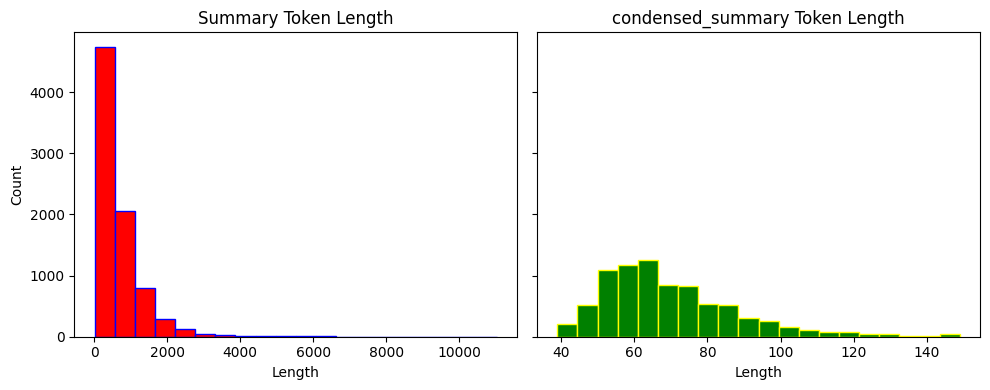

In [ ]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

dialogue_token_len = [len(list(tokenizer.encode(s))) for s in df2['summary']]

summary_token_len = [len(list(tokenizer.encode(s))) for s in df2['condensed_summary']]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(dialogue_token_len, bins = 20, color = 'r', edgecolor = 'b' )
axes[0].set_title("Summary Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'green', edgecolor = 'yellow' )
axes[1].set_title("condensed_summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

# 3. Computer Vision Component:
   - Convert the condensed text summaries into images using a Text-to-Image model.

In [ ]:
csv_file = '/content/drive/MyDrive/Data Colab/book_summariesed.csv'
df = pd.read_csv(csv_file)

In [ ]:
def text_to_image_StableDiffusionPipeline(text, output_path, model_id="runwayml/stable-diffusion-v1-5", use_cuda=True):
    """Generates an image based on a text prompt using Stable Diffusion.

  Args:
      text (str): The text prompt describing the desired image.
      output_path (str): The path to save the generated image.
      model_id (str, optional): The ID of the pre-trained Stable Diffusion model. Defaults to "runwayml/stable-diffusion-v1-5".
      use_cuda (bool, optional): Whether to use CUDA for faster generation if available. Defaults to True.
  """
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    if use_cuda and torch.cuda.is_available():
      pipe = pipe.to("cuda")

    image = pipe(text).images[0]
    image.save(output_path)
    return image


0it [00:00, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Summary 1 _ Animal Farm converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_0_Animal Farm.png


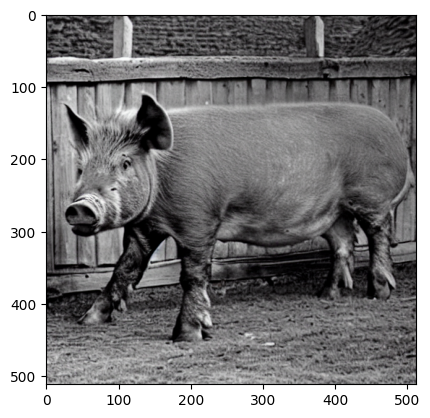

1it [00:35, 35.82s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (81 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ultra - violence.']


  0%|          | 0/50 [00:00<?, ?it/s]

2it [01:11, 35.58s/it]

Summary 2 _ A Clockwork Orange converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_1_A Clockwork Orange.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

3it [01:45, 34.94s/it]

Summary 3 _ The Plague converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_2_The Plague.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

4it [02:20, 35.12s/it]

Summary 4 _ An Enquiry Concerning Human Understanding converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_3_An Enquiry Concerning Human Understanding.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (101 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['compromised by a dormant super - intelligent entity ( actually encoded within the archive ) later known as the blight.']


  0%|          | 0/50 [00:00<?, ?it/s]

5it [02:56, 35.16s/it]

Summary 5 _ A Fire Upon the Deep converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_4_A Fire Upon the Deep.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

6it [03:29, 34.74s/it]

Summary 6 _ All Quiet on the Western Front converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_5_All Quiet on the Western Front.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ged, and taken as an apprentice.']


  0%|          | 0/50 [00:00<?, ?it/s]

7it [04:04, 34.76s/it]

Summary 7 _ A Wizard of Earthsea converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_6_A Wizard of Earthsea.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

8it [04:39, 34.64s/it]

Summary 8 _ Anyone Can Whistle converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_7_Anyone Can Whistle.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

9it [05:13, 34.47s/it]

Summary 9 _ Blade Runner 3: Replicant Night converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_8_Blade Runner 3: Replicant Night.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

10it [05:46, 34.19s/it]

Summary 10 _ Blade Runner 2: The Edge of Human converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_9_Blade Runner 2: The Edge of Human.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Summary 11 _ Book of Joshua converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_10_Book of Joshua.png


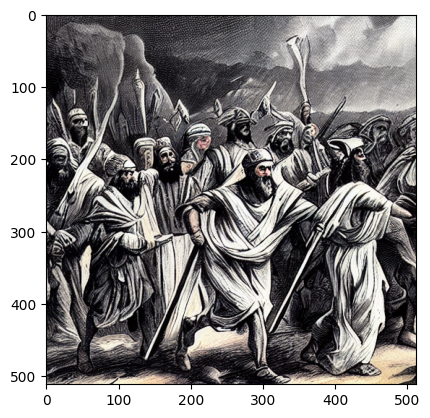

11it [06:21, 34.31s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

12it [06:55, 34.23s/it]

Summary 12 _ Book of Ezra converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_11_Book of Ezra.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

13it [07:29, 34.12s/it]

Summary 13 _ Book of Numbers converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_12_Book of Numbers.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (100 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['to their own mothers, and remarry. however, ruth says, " entreat me not to leave you "']


  0%|          | 0/50 [00:00<?, ?it/s]

14it [08:02, 33.74s/it]

Summary 14 _ Book of Ruth converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_13_Book of Ruth.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (147 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["should be the ruler of their households. one of these is the orphan esther, whose jewish name is hadassah. she finds favor in the king's eyes, and is made his new queen. esther does not reveal that she is jewish. shortly afterwards, mordechai discovers a plot by courtiers bigthan and teresh to assassinate ah"]


  0%|          | 0/50 [00:00<?, ?it/s]

15it [08:34, 33.22s/it]

Summary 15 _ Book of Esther converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_14_Book of Esther.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (117 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['themselves to god, and god asks satan his opinion on job. satan answers that job is pious only because god has put a " wall around " him and " blessed " his favourite servant with prosperity.']


  0%|          | 0/50 [00:00<?, ?it/s]

16it [09:06, 32.85s/it]

Summary 16 _ Book of Job converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_15_Book of Job.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

17it [09:44, 34.53s/it]

Summary 17 _ Book of Hosea converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_16_Book of Hosea.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

18it [10:17, 34.10s/it]

Summary 18 _ Book of Jonah converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_17_Book of Jonah.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

19it [10:50, 33.81s/it]

Summary 19 _ Book of Micah converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_18_Book of Micah.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

20it [11:24, 33.74s/it]

Summary 20 _ Book of Haggai converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_19_Book of Haggai.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Summary 21 _ Crash converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_20_Crash.png


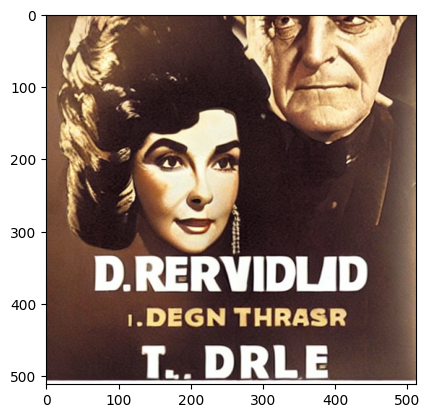

21it [11:58, 33.76s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

22it [12:31, 33.63s/it]

Summary 22 _ Children of Dune converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_21_Children of Dune.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["baron's daughter, lady cunégonde."]


  0%|          | 0/50 [00:00<?, ?it/s]

23it [13:05, 33.74s/it]

Summary 23 _ Candide, ou l'Optimisme converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_22_Candide, ou l'Optimisme.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

24it [13:39, 33.72s/it]

Summary 24 _ Chapterhouse Dune converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_23_Chapterhouse Dune.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

25it [14:13, 33.82s/it]

Summary 25 _ Carmilla converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_24_Carmilla.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (121 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['a secret affair that lasts some 1 5 years. many years later, teenaged angel falls in love with rose rose, the daughter of the head migrant worker at the apple orchard, and homer performs an abortion on her.']


  0%|          | 0/50 [00:00<?, ?it/s]

26it [14:47, 33.92s/it]

Summary 26 _ The Cider House Rules converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_25_The Cider House Rules.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

27it [15:21, 33.93s/it]

Summary 27 _ Dracula converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_26_Dracula.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ry.']


  0%|          | 0/50 [00:00<?, ?it/s]

28it [15:55, 33.98s/it]

Summary 28 _ Don Quixote converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_27_Don Quixote.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

29it [16:29, 34.07s/it]

Summary 29 _ Deuteronomy converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_28_Deuteronomy.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

30it [17:04, 34.30s/it]

Summary 30 _ Dune Messiah converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_29_Dune Messiah.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Summary 31 _ Darwin's Dangerous Idea converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_30_Darwin's Dangerous Idea.png


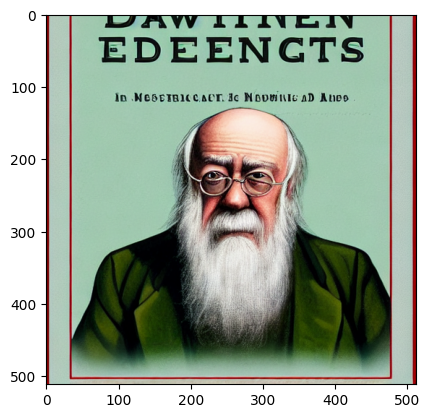

31it [17:39, 34.42s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

32it [18:13, 34.42s/it]

Summary 32 _ Death of a Hero converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_31_Death of a Hero.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

33it [18:48, 34.46s/it]

Summary 33 _ Exodus converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_32_Exodus.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

34it [19:23, 34.63s/it]

Summary 34 _ The Trial converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_33_The Trial.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (86 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['afraid that his appearance will frighten her.']


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
35it [19:59, 35.22s/it]

Summary 35 _ The Metamorphosis converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_34_The Metamorphosis.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

36it [20:34, 35.09s/it]

Summary 36 _ Fahrenheit 451 converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_35_Fahrenheit 451.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (101 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['buss shot in his general direction. his reputation spreads across the kingdom, and he is rewarded by the king.']


  0%|          | 0/50 [00:00<?, ?it/s]

37it [21:07, 34.49s/it]

Summary 37 _ Farmer Giles of Ham converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_36_Farmer Giles of Ham.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

38it [21:38, 33.27s/it]

Summary 38 _ Gaudy Night converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_37_Gaudy Night.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (93 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the gods and arrives in some other place, where he finds a great palace.']


  0%|          | 0/50 [00:00<?, ?it/s]

39it [22:09, 32.59s/it]

Summary 39 _ Gylfaginning converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_38_Gylfaginning.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
40it [22:39, 31.88s/it]

Summary 40 _ God Emperor of Dune converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_39_God Emperor of Dune.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (95 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', but god has promised that he will not destroy the world a second time with water.']


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Summary 41 _ Genesis converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_40_Genesis.png


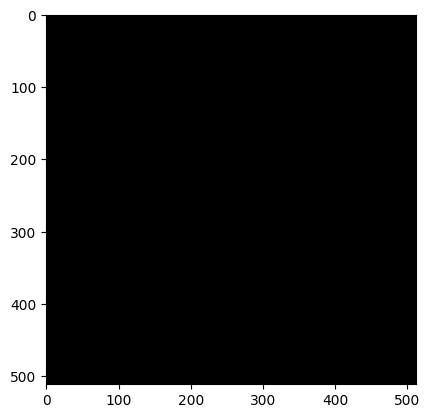

41it [23:09, 31.40s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

42it [23:39, 31.04s/it]

Summary 42 _ Gone with the Wind converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_41_Gone with the Wind.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

43it [24:09, 30.68s/it]

Summary 43 _ Heart of Darkness converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_42_Heart of Darkness.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

44it [24:39, 30.30s/it]

Summary 44 _ Hamlet converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_43_Hamlet.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the bene tleilax, and the bene gesserit.']


  0%|          | 0/50 [00:00<?, ?it/s]

45it [25:08, 30.11s/it]

Summary 45 _ Heretics of Dune converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_44_Heretics of Dune.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

46it [25:38, 29.97s/it]

Summary 46 _ Adventures of Huckleberry Finn converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_45_Adventures of Huckleberry Finn.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

47it [26:08, 30.03s/it]

Summary 47 _ Ivanhoe converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_46_Ivanhoe.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (89 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['tracheotomy which he can neither remove nor control.']


  0%|          | 0/50 [00:00<?, ?it/s]

48it [26:40, 30.57s/it]

Summary 48 _ Johnny Got His Gun converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_47_Johnny Got His Gun.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

49it [27:13, 31.31s/it]

Summary 49 _ Icehenge converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_48_Icehenge.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

50it [27:46, 31.79s/it]

Summary 50 _ Leviticus converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_49_Leviticus.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Summary 51 _ Leaf by Niggle converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_50_Leaf by Niggle.png


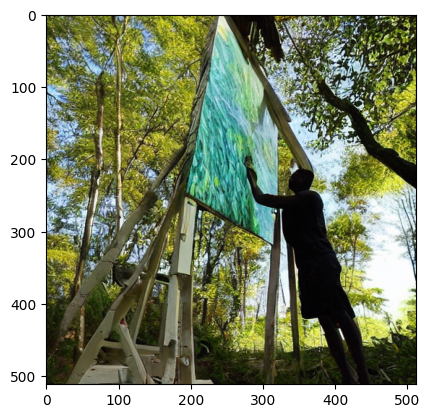

51it [28:18, 32.01s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

52it [28:52, 32.40s/it]

Summary 52 _ Macbeth converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_51_Macbeth.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

53it [29:23, 32.17s/it]

Summary 53 _ Microserfs converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_52_Microserfs.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

54it [29:54, 31.80s/it]

Summary 54 _ Moby-Dick; or, The Whale converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_53_Moby-Dick; or, The Whale.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (116 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['there is a flood. while attending the sunday service at church, john hears strange sounds from the crypt below. he thinks it is the sound of the coffins of the mohune family.']


  0%|          | 0/50 [00:00<?, ?it/s]

55it [30:24, 31.11s/it]

Summary 55 _ Moonfleet converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_54_Moonfleet.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

56it [31:01, 33.03s/it]

Summary 56 _ Neuromancer converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_55_Neuromancer.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (108 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['waterhouse joins his old dungeons and dragons companion avi halaby in a new startup, providing pinoy - grams to migrant filipinos via new fiber - optic cables.']


  0%|          | 0/50 [00:00<?, ?it/s]

57it [31:38, 33.98s/it]

Summary 57 _ Cryptonomicon converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_56_Cryptonomicon.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

58it [32:14, 34.60s/it]

Summary 58 _ No Logo converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_57_No Logo.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

59it [32:50, 35.08s/it]

Summary 59 _ Odyssey converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_58_Odyssey.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (144 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['des demona and had previously asked her father for her hand in marriage. igo is also angry because he believes, or at least gives the pretence of belief, that o thello slept with his wife emilia. he denounces cassio as a scholarly tactician with no real battle experience ; in contrast, iago was a']


  0%|          | 0/50 [00:00<?, ?it/s]

60it [33:26, 35.32s/it]

Summary 60 _ Othello converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_59_Othello.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Summary 61 _ On War converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_60_On War.png


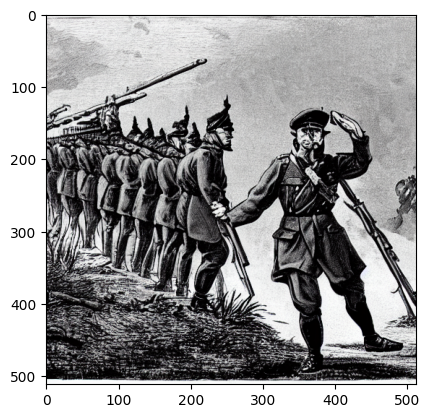

61it [34:03, 35.85s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (88 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of escapism involving the use of an illegal drug.']


  0%|          | 0/50 [00:00<?, ?it/s]

62it [34:39, 35.95s/it]

Summary 62 _ The Three Stigmata of Palmer Eldritch converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_61_The Three Stigmata of Palmer Eldritch.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

63it [35:15, 36.11s/it]

Summary 63 _ Time out of Joint converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_62_Time out of Joint.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

64it [35:52, 36.11s/it]

Summary 64 _ A Scanner Darkly converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_63_A Scanner Darkly.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

65it [36:27, 36.07s/it]

Summary 65 _ Radio Free Albemuth converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_64_Radio Free Albemuth.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['very seriously mistreated bymr darcy.']


  0%|          | 0/50 [00:00<?, ?it/s]

66it [37:04, 36.28s/it]

Summary 66 _ Pride and Prejudice converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_65_Pride and Prejudice.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

67it [37:41, 36.28s/it]

Summary 67 _ Pale Fire converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_66_Pale Fire.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

68it [38:17, 36.21s/it]

Summary 68 _ Pacific Overtures converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_67_Pacific Overtures.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (110 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["cousin romeo, montague's son, about romeo's recent depression. he discovers that it stems from unrequited infatuation for a girl named rosaline."]


  0%|          | 0/50 [00:00<?, ?it/s]

69it [38:52, 36.10s/it]

Summary 69 _ Romeo and Juliet converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_68_Romeo and Juliet.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

70it [39:29, 36.19s/it]

Summary 70 _ Rosencrantz & Guildenstern Are Dead converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_69_Rosencrantz & Guildenstern Are Dead.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ringworld.']


  0%|          | 0/50 [00:00<?, ?it/s]

Summary 71 _ Ringworld converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_70_Ringworld.png


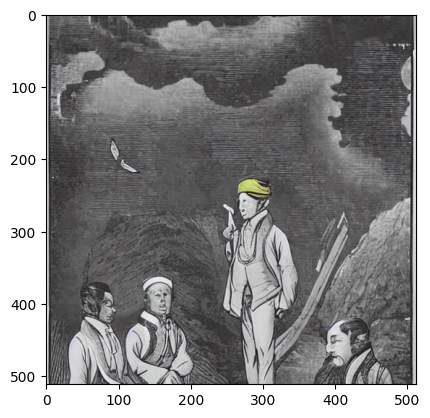

71it [40:05, 36.31s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of love ")']


  0%|          | 0/50 [00:00<?, ?it/s]

72it [40:41, 36.14s/it]

Summary 72 _ Rent converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_71_Rent.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (123 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['our solar system. the 2 0 + crew, led by commander bill norton, enters rama through triple airlocks, and explores the vast 1 6 - km wide by 5 0 - km long cylindrical world of its interior.']


  0%|          | 0/50 [00:00<?, ?it/s]

73it [41:19, 36.69s/it]

Summary 73 _ Rendezvous with Rama converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_72_Rendezvous with Rama.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

74it [41:58, 37.24s/it]

Summary 74 _ Sense and Sensibility converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_73_Sense and Sensibility.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

75it [42:36, 37.57s/it]

Summary 75 _ Speaker for the Dead converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_74_Speaker for the Dead.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

76it [43:14, 37.66s/it]

Summary 76 _ Starship Troopers converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_75_Starship Troopers.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

77it [43:52, 37.78s/it]

Summary 77 _ Sir Gawain and the Green Knight converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_76_Sir Gawain and the Green Knight.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

78it [44:30, 37.80s/it]

Summary 78 _ Stuart Little converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_77_Stuart Little.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['lum.']


  0%|          | 0/50 [00:00<?, ?it/s]

79it [45:06, 37.21s/it]

Summary 79 _ The Lord of the Rings converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_78_The Lord of the Rings.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['naked existence "']


  0%|          | 0/50 [00:00<?, ?it/s]

80it [45:41, 36.77s/it]

Summary 80 _ The Doors of Perception converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_79_The Doors of Perception.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (96 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and returns at dinner the following week to recount a remarkable tale, becoming the new narrator.']


  0%|          | 0/50 [00:00<?, ?it/s]

Summary 81 _ The Time Machine converted to image: /content/drive/MyDrive/Data Colab/generated_images_all/summary_80_The Time Machine.png


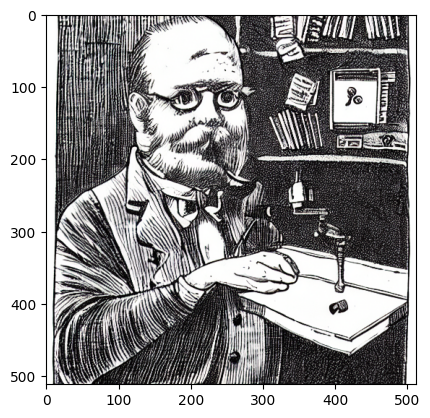

81it [46:18, 36.76s/it]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

81it [46:52, 34.73s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

output_dir = "/content/drive/MyDrive/Data Colab/generated_images_all"
os.makedirs(output_dir, exist_ok=True)

for i, (summary, title) in tqdm(enumerate(zip(df["condensed_summary"], df["title"]))):
    image_path = os.path.join(output_dir, f"summary_{i}_{title}.png")
    image = text_to_image_StableDiffusionPipeline(summary, image_path)
    print(f"Summary {i + 1} _ {title} converted to image:", image_path)
    if i % 10 == 0 :
      plt.imshow(image)
      plt.show()